In [1]:
import os
import json

from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
# Read json sequence data
with open('./files/json/sequence.json') as f:
    data = np.array(json.load(f))
print(data[0])

[[0.49095 0.29687]
 [0.32731 0.24863]]


In [3]:
def generator(data, seq_len, min_index, max_index,
              shuffle=False, batch_size=32):
    i = min_index
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), seq_len, data.shape[-1]))
        targets = np.zeros((len(rows), data.shape[-1]))
        for j, row in enumerate(rows):
            indices = range(rows[j], rows[j] + seq_len)
            samples[j] = data[:, 0, :][indices]
            targets[j] = data[:, 1, :][indices][0]
        yield samples, targets

In [4]:
seq_len = 4                 # Length of sequence to observe
batch_size = 64             # How many sequences per batch
epochs = 10                 # Epochs to train
steps_per_epoch = 10        # Steps per epoch to train
split = 0.9                 # Percentage of test + validation split

# Split in 3 sets for training, validation and testing
test_steps = round((split / 2) * len(data))
val_steps = test_steps
train_steps = len(data) - test_steps - val_steps

train_gen = generator(data,
                      seq_len=seq_len,
                      min_index=0,
                      max_index=train_steps,
                      shuffle=True,
                      batch_size=batch_size)

val_gen = generator(data,
                    seq_len=seq_len,
                    min_index=train_steps + 1,
                    max_index=train_steps + val_steps + 1,
                    batch_size=batch_size)

test_gen = generator(data,
                     seq_len=seq_len,
                     min_index=train_steps + val_steps + 2,
                     max_index=len(data),
                     batch_size=batch_size)

In [5]:
# A very simple RNN model
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, data.shape[-1])))
model.add(layers.Dense(2))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3360      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 3,426
Trainable params: 3,426
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Training
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
10/10 [==============================] - 3s 278ms/step - loss: 0.3035 - val_loss: 0.2123
Epoch 2/10
10/10 [==============================] - 2s 211ms/step - loss: 0.1435 - val_loss: 0.1192
Epoch 3/10
10/10 [==============================] - 2s 219ms/step - loss: 0.0743 - val_loss: 0.1136
Epoch 4/10
10/10 [==============================] - 2s 211ms/step - loss: 0.0689 - val_loss: 0.1026
Epoch 5/10
10/10 [==============================] - 2s 206ms/step - loss: 0.0593 - val_loss: 0.0984
Epoch 6/10
10/10 [==============================] - 2s 228ms/step - loss: 0.0561 - val_loss: 0.1021
Epoch 7/10
10/10 [==============================] - 2s 216ms/step - loss: 0.0501 - val_loss: 0.0957
Epoch 8/10
10/10 [==============================] - 2s 225ms/step - loss: 0.0463 - val_loss: 0.1063
Epoch 9/10
10/10 [==============================] - 2s 205ms/step - loss: 0.0457 - val_loss: 0.1045
Epoch 10/10
10/10 [==============================] - 2s 225ms/step - loss: 0.0423 - val_loss: 0.1021

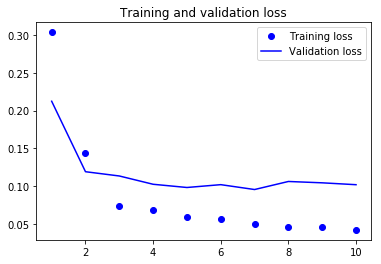

In [7]:
# Plot validation loss and loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
# Naive way of calculating a score with test data
scores = []
for i in range((test_steps // batch_size) + 1):
    samples, targets = next(test_gen)
    result = model.predict(np.array([samples[i]]))
    dist = 1.0 - np.linalg.norm(result[0] - targets[i])
    scores.append(dist)
score_total = np.average(scores)
print('Score: {0:.2f}%'.format(score_total * 100))

Score: 86.76%
